In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

# Number of bootstrap samples you want to generate
num_bootstrap_samples = 100

# Perform bootstrap sampling
bootstrap_samples = [df_5.sample(n=len(df_5), replace=True) for _ in range(num_bootstrap_samples)]

R_cible = 0.10  # Rendement espéré du portefeuille cible

# Initialize lists to store efficient frontier data
all_volatilities = []
all_returns = []

for bootstrap_df in bootstrap_samples:
    bootstrap_df = bootstrap_df.values / 100
    sigma_boot = np.cov(bootstrap_df, rowvar=False)
    z_barre = np.mean(bootstrap_df, axis=0)
    Z_barre = z_barre
    ones = np.ones(len(Z_barre))  # Vecteur de uns

    # Your optimization code goes here...
       # Inversion de la matrice de covariance
    Sigma_inv = np.linalg.inv(sigma_boot)

    # Construction de la matrice A et du vecteur b
    A = np.array([
        [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
        [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
    ])
    b = np.array([1, R_cible])

    # Inversion de la matrice A
    A_inv = np.linalg.inv(A)
    
    # Résolution pour obtenir les multiplicateurs de Lagrange
    lambda_theta = np.dot(A_inv, b)

    # Calcul des poids optimaux du portefeuille
    w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

    # Calculations for efficient frontier...

    # Étendre l'intervalle des rendements cibles pour la frontière complète
    rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

    # Calcul des volatilités et des rendements pour la frontière complète
    volatilites_optimales_etendues = []
    rendements_optimaux_etendus = []
    for R_cible in rendements_cibles_etendus:
        b = np.array([1, R_cible])
        lambda_theta = np.dot(A_inv, b)
        wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
        rendement_optimal = np.dot(wi_optimal, Z_barre)
        volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
        rendements_optimaux_etendus.append(rendement_optimal)
        volatilites_optimales_etendues.append(volatilite_optimale)


    # Store data for efficient frontier
    all_volatilities.append(volatilites_optimales_etendues)
    all_returns.append(rendements_optimaux_etendus)
    
    # Risk-free rate (you need to define your risk-free rate)
    rf = 0.0044

    # Calculate the slope of the CML
    CML_slope = (max(rendements_optimaux_etendus) - rf) / max(volatilites_optimales_etendues)

    # Generate standard deviations for the CML
    CML_std = np.linspace(0, max(volatilites_optimales_etendues), 100)

    # Calculate corresponding expected returns for the CML
    CML_ret = rf + CML_slope * CML_std

    # Calculate Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux_etendus, volatilites_optimales_etendues)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = rendements_optimaux_etendus[max_sharpe_index]
    tangent_portfolio_volatility = volatilites_optimales_etendues[max_sharpe_index]


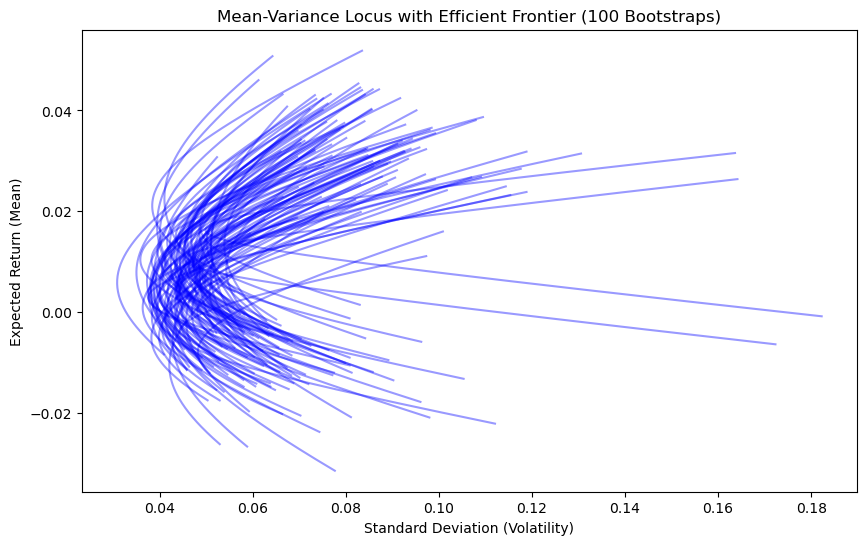

In [4]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency
# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
#plt.grid(True)
plt.show()

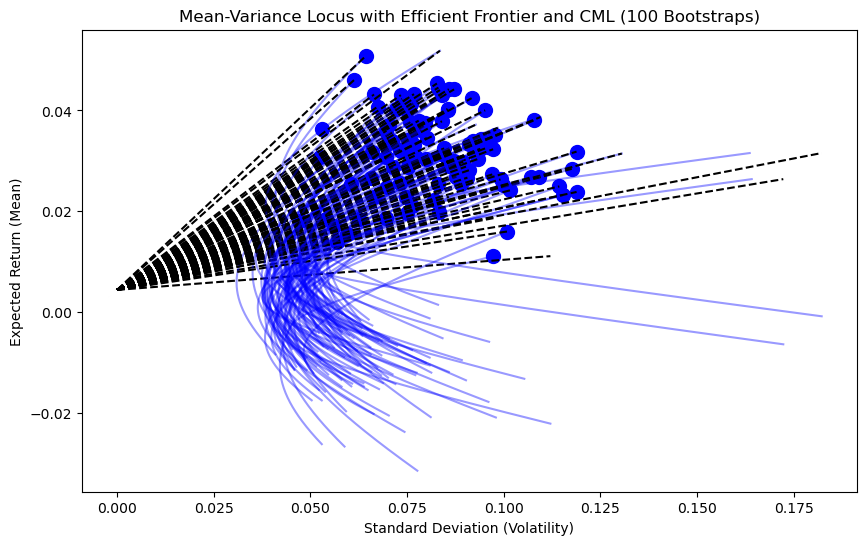

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency

    # Calculate the slope of the CML
    CML_slope = (max(returns) - rf) / max(volatilities)

    # Generate standard deviations for the CML
    CML_std = np.linspace(0, max(volatilities), 100)

    # Calculate corresponding expected returns for the CML
    CML_ret = rf + CML_slope * CML_std

    # Calculate Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(returns, volatilities)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = returns[max_sharpe_index]
    tangent_portfolio_volatility = volatilities[max_sharpe_index]

    # Plot Capital Market Line and Tangent Portfolio
    plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
    plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')

# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier and CML (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.show()


In [6]:
# Initialize lists to store weights, means, and variances of tangent portfolios
all_tangent_portfolio_weights = []
all_tangent_portfolio_means = []
all_tangent_portfolio_variances = []

# Loop for efficient frontier calculation
for volatilities, returns in zip(all_volatilities, all_returns):
    # Calculate the Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(returns, volatilities)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = returns[max_sharpe_index]
    tangent_portfolio_volatility = volatilities[max_sharpe_index]

    # Calculate the weights of the tangent portfolio
    tangent_portfolio_weights = w_optimal  # Use the weights you calculated earlier

    # Calculate the mean of the tangent portfolio
    tangent_portfolio_mean = np.dot(tangent_portfolio_weights, Z_barre)

    # Calculate the variance of the tangent portfolio
    tangent_portfolio_variance = np.dot(tangent_portfolio_weights.T, np.dot(sigma_boot, tangent_portfolio_weights))

    # Append the values to the lists
    all_tangent_portfolio_weights.append(tangent_portfolio_weights)
    all_tangent_portfolio_means.append(tangent_portfolio_mean)
    all_tangent_portfolio_variances.append(tangent_portfolio_variance)

all_tangent_portfolio_weights ,all_tangent_portfolio_means, all_tangent_portfolio_variances


([array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.4647975 , -0.09950152,  2.05847547, -0.84438173,  0.35020528]),
  array([-0.

In [12]:
# Initialize lists to store weights, means, and variances of tangent portfolios
all_tangent_portfolio_weights = []
all_tangent_portfolio_means = []
all_tangent_portfolio_variances = []

# Loop for efficient frontier calculation
for volatilities, returns in zip(all_volatilities, all_returns):
    # Calculate the Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(returns, volatilities)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = returns[max_sharpe_index]
    tangent_portfolio_volatility = volatilities[max_sharpe_index]

    # Calculate the weights of the tangent portfolio

    # Inversion de la matrice de covariance
    Sigma_inv = np.linalg.inv(sigma_boot)

    # Construction de la matrice A et du vecteur b
    A = np.array([
        [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
        [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
    ])
    b = np.array([1, tangent_portfolio_return])

    # Inversion de la matrice A
    A_inv = np.linalg.inv(A)
    
    # Résolution pour obtenir les multiplicateurs de Lagrange
    lambda_theta = np.dot(A_inv, b)

    # Calcul des poids optimaux du portefeuille
    tangent_portfolio_weights = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

    # Calculate the mean of the tangent portfolio
    tangent_portfolio_mean = np.dot(tangent_portfolio_weights, Z_barre)

    # Calculate the variance of the tangent portfolio
    tangent_portfolio_variance = np.dot(tangent_portfolio_weights.T, np.dot(sigma_boot, tangent_portfolio_weights))

    # Append the values to the lists
    all_tangent_portfolio_weights.append(tangent_portfolio_weights)
    all_tangent_portfolio_means.append(tangent_portfolio_mean)
    all_tangent_portfolio_variances.append(tangent_portfolio_variance)

all_tangent_portfolio_weights, all_tangent_portfolio_means, all_tangent_portfolio_variances


([array([ 0.0867749 , -0.17164594,  0.04709352,  0.57957605,  0.45820147]),
  array([-0.73448045, -0.06422761,  3.04191017, -1.54060429,  0.29740218]),
  array([ 0.05247849, -0.16716004,  0.17215992,  0.4910353 ,  0.45148634]),
  array([-0.30835182, -0.11996426,  1.48797552, -0.44049631,  0.38083687]),
  array([ 0.09674282, -0.17294972,  0.01074417,  0.60530957,  0.46015316]),
  array([-0.36440025, -0.11263325,  1.6923636 , -0.58519284,  0.36986275]),
  array([-0.12825344, -0.14352072,  0.83122289,  0.02445169,  0.41609958]),
  array([-0.57664095, -0.08487265,  2.46632748, -1.13312054,  0.32830667]),
  array([-0.17500975, -0.1374051 ,  1.00172598, -0.09625597,  0.40694484]),
  array([-0.40292036, -0.10759491,  1.83283227, -0.68463763,  0.36232064]),
  array([-0.56380092, -0.0865521 ,  2.41950459, -1.09997228,  0.33082071]),
  array([-0.25483759, -0.1269638 ,  1.29282881, -0.30234221,  0.39131479]),
  array([-0.31557433, -0.11901957,  1.5143134 , -0.45914221,  0.37942272]),
  array([-0.

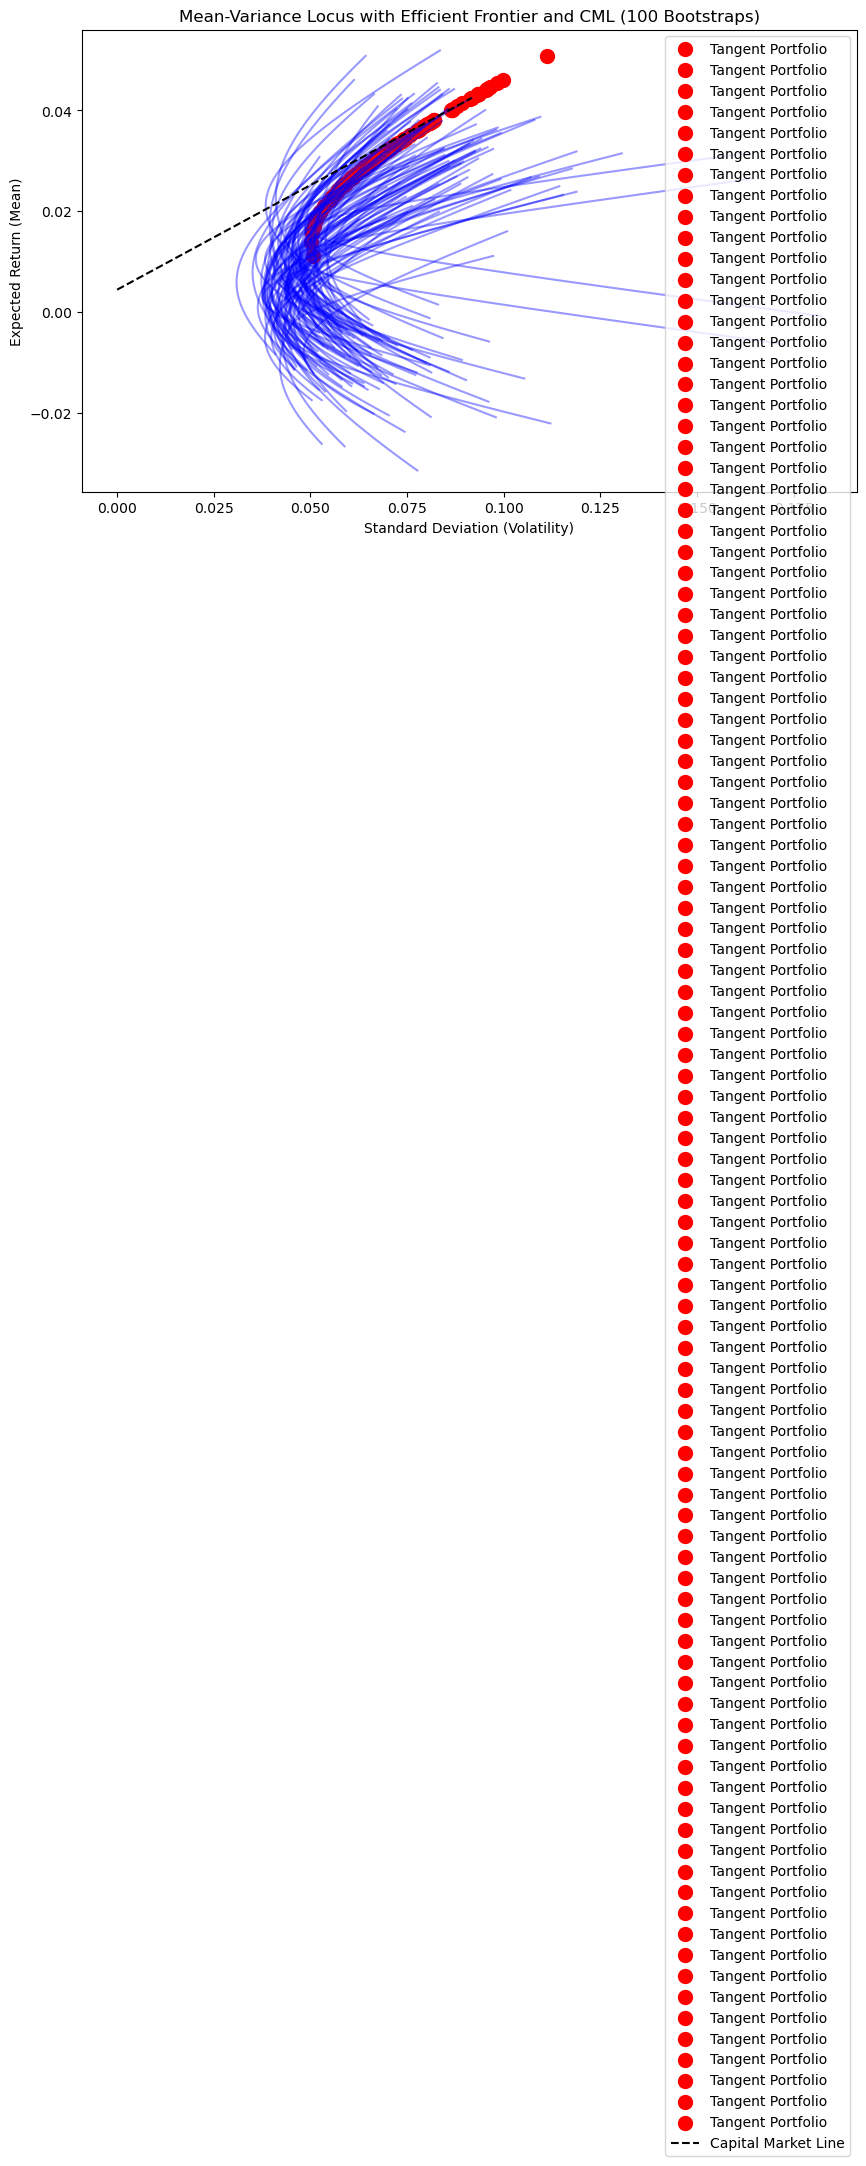

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency

# Loop for plotting tangent portfolios
for weights, mean in zip(all_tangent_portfolio_weights, all_tangent_portfolio_means):
    volatility = np.sqrt(all_tangent_portfolio_variances[all_tangent_portfolio_means.index(mean)])
    plt.scatter(volatility, mean, color='red', marker='o', s=100, label='Tangent Portfolio')

# Plot Capital Market Line
plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')

# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier and CML (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.show()
